In [1]:
#@title (Hidden) Diagnostic Check
import os
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset
!git clone https://github.com/davda54/sam.git
#sam 
from sam.sam import SAM

%matplotlib inline

print(f"\nPython environment:\n{sys.version}")
print("\nStatistical packages loaded: ")
print(f"numpy: {np.__version__}")
print(f"pytorch: {torch.__version__}")

# Detect if a GPU is present with CUDA support
use_cuda = torch.cuda.is_available()
print(f"GPU Enabled: {use_cuda}")

print(f"\nRuntime location:")
try:
  from google.colab import drive
  is_google_colab = True
  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")

seed = 1943
torch.manual_seed(seed)
np.random.seed(seed)
print(f"\nRandom Seed: {seed}")
print("SAM library is imported")


Cloning into 'sam'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 179 (delta 62), reused 53 (delta 53), pack-reused 104
Receiving objects: 100% (179/179), 650.16 KiB | 6.99 MiB/s, done.
Resolving deltas: 100% (84/84), done.

Python environment:
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Statistical packages loaded: 
numpy: 1.19.5
pytorch: 1.10.0+cu111
GPU Enabled: True

Runtime location:
Notebook is on Google CoLab

Random Seed: 1943
SAM library is imported


In [2]:
# stats = ((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding = 4, padding_mode = "reflect"),
    tt.ColorJitter(brightness = 0.05, contrast = 0.05, saturation = 0.05, hue = 0.05),
    tt.RandomAffine(degrees = (-1, 1), translate = (0.01, 0.05)), 
    tt.ToTensor(),
    # tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    # tt.Normalize(*stats)
])

In [3]:
train = CIFAR100(download = True, root= "./data", transform = train_transform)
test = CIFAR100(root = "./data", train = False, transform = test_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [4]:
# checking the data
for image, label in train:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[0.4863, 0.5490, 0.5961,  ..., 0.9922, 0.9882, 0.9922],
         [0.6118, 0.5961, 0.6039,  ..., 0.9922, 0.9882, 0.9922],
         [0.6667, 0.7020, 0.6863,  ..., 0.9922, 0.9882, 0.9922],
         ...,
         [0.2745, 0.2471, 0.1137,  ..., 0.5059, 0.5098, 0.5412],
         [0.3098, 0.2706, 0.1882,  ..., 0.5804, 0.5804, 0.5608],
         [0.3686, 0.3137, 0.2824,  ..., 0.6706, 0.6314, 0.6039]],

        [[0.5176, 0.5882, 0.6353,  ..., 0.9922, 0.9882, 0.9922],
         [0.6392, 0.6157, 0.5882,  ..., 0.9922, 0.9882, 0.9922],
         [0.7176, 0.7176, 0.6392,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.2980, 0.2510, 0.0784,  ..., 0.6941, 0.7059, 0.7176],
         [0.3059, 0.2510, 0.1451,  ..., 0.7725, 0.7843, 0.7529],
         [0.3451, 0.2784, 0.2353,  ..., 0.8549, 0.8196, 0.7922]],

        [[0.4353, 0.4471, 0.4627,  ..., 0.9922, 0.9882, 0.9922],
         [0.6431, 0.5804, 0.5059,  ..., 0.9922, 0.9882, 0.9922],
     

In [5]:
# checking the 100 different classes that should be present in the training set
print(len(set(train.classes)))

100


In [6]:
# check train / test datasets
# creates dictionaries of each class in train / test and how many images are in each class
train_items = dict()
test_items = dict()

for train_item in train:
    label = train.classes[train_item[1]]
    if label not in train_items:
        train_items[label] = 1
    else:
        train_items[label] += 1

for test_item in test:
    label = test.classes[test_item[1]]
    if label not in test_items:
        test_items[label] = 1
    else:
        test_items[label] += 1

In [7]:
# check train / test datasets continued
# running this code chunk should produce no output
for i in train_items:
    # train and test should both have 100 different classes
    if i not in test_items: 
        print(False)
        break
    # train should have 500 of each class and test should have 100 of each class
    if train_items[i] != 500 and test_items[i] != 100: 
        print(False)
        break

Technically we could split the training set further into a train-dev-test, but with only 600 images for each class (500 in training and 100 in test), it doesn't make that much sense to thin out the data further. 

In [8]:
BATCH_SIZE = 512
train_dl = DataLoader(train, BATCH_SIZE, num_workers = 2, pin_memory = True, shuffle = True)
test_dl = DataLoader(test, BATCH_SIZE, num_workers = 2, pin_memory = True)

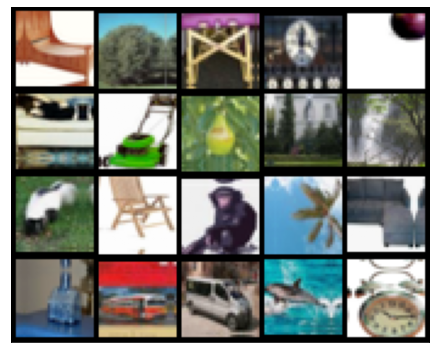

In [9]:
def show_batch(dl):
    for batch in dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize = (7.5, 7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20], nrow = 5).permute(1, 2, 0))
        break

show_batch(train_dl)

In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)

In [11]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl,device)
test_dl = ToDeviceLoader(test_dl,device)

cuda


In [12]:
def accuracy(predicted,actual):
    _, predictions = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

class BaseModel(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
   
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# manifold mixup code source: https://www.kaggle.com/hocop1/manifold-mixup-using-pytorch
def mixup(x, shuffle, lam, i, j):
    if shuffle is not None and lam is not None and i == j:
        x = lam * x + (1 - lam) * x[shuffle]
    return x
    

class ResNet152(BaseModel):
    def __init__(self, in_channels, num_classes):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.resnet34(pretrained=True)
#         # Replace last layer
#         num_ftrs = self.network.fc.in_features
#         self.network.fc = nn.Linear(num_ftrs, num_classes)
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1024, pool=True)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, 512),
                                        nn.Linear(512, 256),
                                        nn.Linear(256,128),
                                        nn.Linear(128,num_classes))
        
    
#     def forward(self, xb):
        
#         return torch.relu(self.network(xb))
    def forward(self, xb):
        if isinstance(xb, list):
          xb, shuffle, lam = xb
        else:
          shuffle = None
          lam = None

        j = np.random.randint(9)
        
        xb = mixup(xb, shuffle, lam, 0, j)
        out = self.conv1(xb)
        out = mixup(out, shuffle, lam, 1, j)
        out = self.conv2(out)
        out = mixup(out, shuffle, lam, 2, j)
        out = self.res1(out) + out
        out = mixup(out, shuffle, lam, 3, j)
        out = self.conv3(out)
        out = mixup(out, shuffle, lam, 4, j)
        out = self.conv4(out)
        out = mixup(out, shuffle, lam, 5, j)
        out = self.res2(out) + out
        out = mixup(out, shuffle, lam, 6, j)
        out = self.conv5(out)
        out = mixup(out, shuffle, lam, 7, j)
        out = self.res3(out) + out
        out = mixup(out, shuffle, lam, 8, j)
        out = self.classifier(out)
        return out

In [13]:
model = to_device(ResNet152(3, 100), device)
model

ResNet152(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [14]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs,train_dl,test_dl,model,optimizer,max_lr,weight_decay,scheduler,grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(),max_lr,weight_decay=weight_decay)
    
    scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [ ]:
def fit2 (epochs,train_dl,test_dl,model,optimizer,max_lr,weight_decay,scheduler,grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    #optimizer = optimizer(model.parameters(),max_lr,weight_decay=weight_decay)
    
    scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            def closure():
              loss = model.training_step(batch)
              loss.backward()
              return loss
  
            optimizer.step(closure)
            optimizer.zero_grad()

            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [15]:
history = [evaluate(model,test_dl)]

In [16]:
print(history)

[{'val_loss': 4.606530666351318, 'val_acc': 0.010110294446349144}]


In [ ]:
#first SAM model with max_lr = 0.01. This probably somehow decreased the SAM learning rate by the way!
epochs = 50
optimizer = torch.optim.SGD
max_lr=0.01
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR
model_opt = SAM(model.parameters(), base_optimizer = optimizer, lr = 0.1, momentum = 0.9)

In [ ]:
%%time
history += fit2(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=model_opt,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00051, train_loss: 4.5245, val_loss: 4.3862, val_acc: 0.0558
Epoch [1], last_lr: 0.00082, train_loss: 4.2544, val_loss: 4.0597, val_acc: 0.0961
Epoch [2], last_lr: 0.00132, train_loss: 3.9108, val_loss: 3.7029, val_acc: 0.1357
Epoch [3], last_lr: 0.00199, train_loss: 3.6050, val_loss: 3.4068, val_acc: 0.1857
Epoch [4], last_lr: 0.00280, train_loss: 3.3276, val_loss: 3.1294, val_acc: 0.2263
Epoch [5], last_lr: 0.00372, train_loss: 3.0570, val_loss: 2.9844, val_acc: 0.2586
Epoch [6], last_lr: 0.00470, train_loss: 2.8031, val_loss: 2.9835, val_acc: 0.2642
Epoch [7], last_lr: 0.00571, train_loss: 2.5882, val_loss: 2.4410, val_acc: 0.3578
Epoch [8], last_lr: 0.00669, train_loss: 2.3990, val_loss: 2.4731, val_acc: 0.3549
Epoch [9], last_lr: 0.00761, train_loss: 2.2228, val_loss: 2.1981, val_acc: 0.4207
Epoch [10], last_lr: 0.00842, train_loss: 2.0694, val_loss: 2.0284, val_acc: 0.4505
Epoch [11], last_lr: 0.00909, train_loss: 1.9400, val_loss: 2.0543, val_acc: 0.4498
Ep

In [ ]:
torch.save(model.state_dict(), '/content/sgdsampoint1lr')

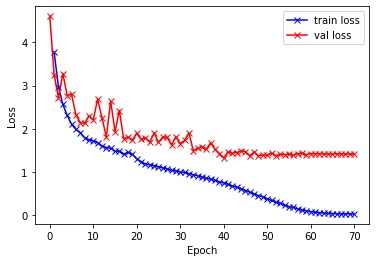

In [ ]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

plot_loss(history)


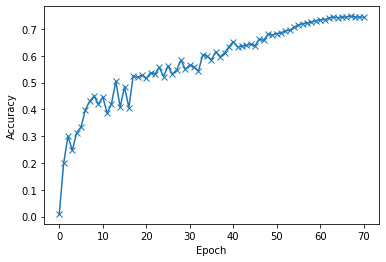

In [ ]:
plot_acc(history)

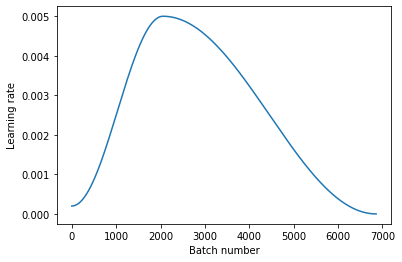

In [ ]:
plot_lrs(history)

lets shove this into the model for a bit longer (with a lower learning rate) cuz why the fuck not

In [ ]:
%%time
history += fit2(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=model_opt,max_lr=0.001,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

In [ ]:
epochs = 50
optimizer = torch.optim.SGD
max_lr=0.1
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR
model_opt = SAM(model.parameters(), base_optimizer = optimizer, lr = 0.1, momentum = 0.9)

In [ ]:
%%time
history += fit2(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=model_opt,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00505, train_loss: 4.1616, val_loss: 3.6139, val_acc: 0.1456
Epoch [1], last_lr: 0.00816, train_loss: 3.3809, val_loss: 3.0643, val_acc: 0.2402
Epoch [2], last_lr: 0.01318, train_loss: 2.9280, val_loss: 3.0072, val_acc: 0.2513
Epoch [3], last_lr: 0.01990, train_loss: 2.6055, val_loss: 2.6203, val_acc: 0.3336
Epoch [4], last_lr: 0.02803, train_loss: 2.3565, val_loss: 2.4622, val_acc: 0.3508
Epoch [5], last_lr: 0.03721, train_loss: 2.1700, val_loss: 2.3765, val_acc: 0.3925
Epoch [6], last_lr: 0.04703, train_loss: 2.0483, val_loss: 2.3882, val_acc: 0.3971
Epoch [7], last_lr: 0.05707, train_loss: 1.9205, val_loss: 2.1262, val_acc: 0.4276
Epoch [8], last_lr: 0.06689, train_loss: 1.8216, val_loss: 1.9696, val_acc: 0.4639
Epoch [9], last_lr: 0.07606, train_loss: 1.7217, val_loss: 2.0364, val_acc: 0.4619
Epoch [10], last_lr: 0.08417, train_loss: 1.6407, val_loss: 1.9189, val_acc: 0.4862
Epoch [11], last_lr: 0.09088, train_loss: 1.5441, val_loss: 2.2084, val_acc: 0.4325
Ep

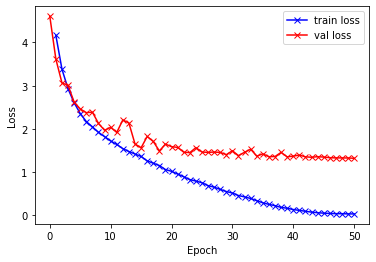

In [ ]:
plot_loss(history)

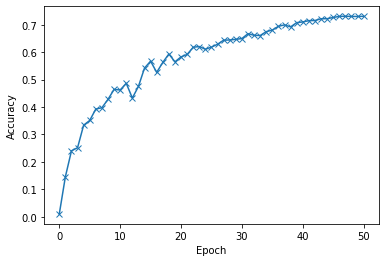

In [ ]:
plot_acc(history)

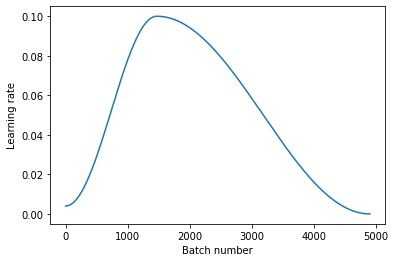

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), '/content/sgdsampoint1maxlr')

In [ ]:
#this code chunk is for setting up the parameters for manifold mixup.
#it looks the same as other code chunks. the code chunks before this ran a model which didn't use manifold mixup though.
#let's throw in SAM too, cuz why not!
epochs = 50
optimizer = torch.optim.SGD
max_lr=0.1
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR
model_opt = SAM(model.parameters(), base_optimizer = optimizer, lr = 0.1, momentum = 0.9)

In [ ]:
%%time
history += fit2(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=model_opt,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00505, train_loss: 4.1608, val_loss: 3.6163, val_acc: 0.1466
Epoch [1], last_lr: 0.00816, train_loss: 3.3809, val_loss: 3.0600, val_acc: 0.2382
Epoch [2], last_lr: 0.01318, train_loss: 2.9278, val_loss: 3.0703, val_acc: 0.2345
Epoch [3], last_lr: 0.01990, train_loss: 2.6179, val_loss: 2.5821, val_acc: 0.3344
Epoch [4], last_lr: 0.02803, train_loss: 2.3607, val_loss: 2.4127, val_acc: 0.3675
Epoch [5], last_lr: 0.03721, train_loss: 2.1735, val_loss: 2.3007, val_acc: 0.3965
Epoch [6], last_lr: 0.04703, train_loss: 2.0454, val_loss: 2.1725, val_acc: 0.4179
Epoch [7], last_lr: 0.05707, train_loss: 1.9332, val_loss: 2.2626, val_acc: 0.4228
Epoch [8], last_lr: 0.06689, train_loss: 1.8270, val_loss: 2.1013, val_acc: 0.4515
Epoch [9], last_lr: 0.07606, train_loss: 1.7282, val_loss: 2.1123, val_acc: 0.4504
Epoch [10], last_lr: 0.08417, train_loss: 1.6528, val_loss: 2.0690, val_acc: 0.4582
Epoch [11], last_lr: 0.09088, train_loss: 1.5563, val_loss: 1.9424, val_acc: 0.4679
Ep

In [ ]:
torch.save(model.state_dict(), '/content/sgdsammanifold')

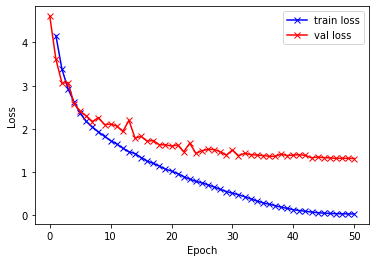

In [ ]:
plot_loss(history)

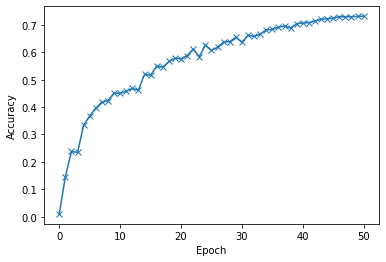

In [ ]:
plot_acc(history)

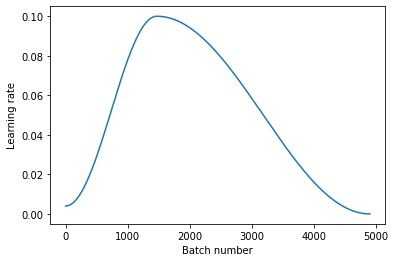

In [ ]:
plot_lrs(history)

In [ ]:
history = [evaluate(model,test_dl)]

In [ ]:
print(history)

[{'val_loss': 77766.5, 'val_acc': 0.009363511577248573}]


In [ ]:
#let's try to use the ADAM optimizer, without SAM, with manifold mixup.
epochs = 50
optimizer = torch.optim.Adam
max_lr=0.005
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [ ]:
%%time
history += fit(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=optimizer,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00025, train_loss: 3.7661, val_loss: 3.2211, val_acc: 0.2062
Epoch [1], last_lr: 0.00041, train_loss: 2.9691, val_loss: 2.7596, val_acc: 0.2943
Epoch [2], last_lr: 0.00066, train_loss: 2.5716, val_loss: 3.1679, val_acc: 0.2673
Epoch [3], last_lr: 0.00100, train_loss: 2.3508, val_loss: 2.3970, val_acc: 0.3717
Epoch [4], last_lr: 0.00140, train_loss: 2.1453, val_loss: 2.8119, val_acc: 0.3308
Epoch [5], last_lr: 0.00186, train_loss: 2.0481, val_loss: 2.5222, val_acc: 0.3690
Epoch [6], last_lr: 0.00235, train_loss: 1.9819, val_loss: 2.9169, val_acc: 0.3246
Epoch [7], last_lr: 0.00285, train_loss: 1.8900, val_loss: 2.8077, val_acc: 0.3676
Epoch [8], last_lr: 0.00334, train_loss: 1.8311, val_loss: 2.3845, val_acc: 0.3868
Epoch [9], last_lr: 0.00380, train_loss: 1.7670, val_loss: 2.2165, val_acc: 0.4410
Epoch [10], last_lr: 0.00421, train_loss: 1.7150, val_loss: 2.3538, val_acc: 0.4159
Epoch [11], last_lr: 0.00454, train_loss: 1.6139, val_loss: 2.1889, val_acc: 0.4209
Ep

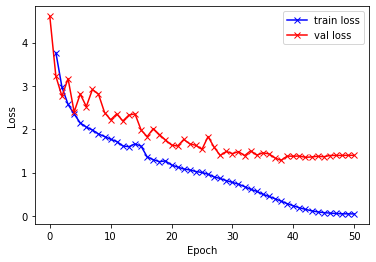

In [ ]:
plot_loss(history)

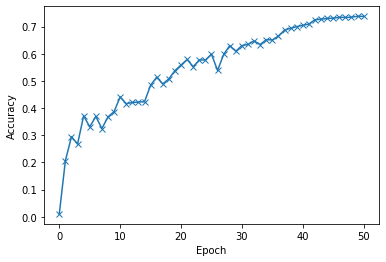

In [ ]:
plot_acc(history)

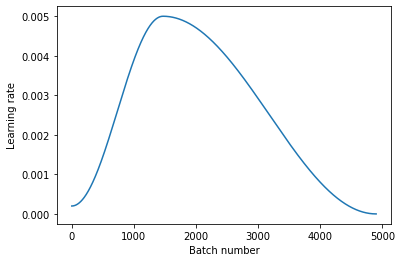

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), '/content/adammanifold')

In [ ]:
#let's try to use the ADAM optimizer again, without SAM, with manifold mixup.
epochs = 70
optimizer = torch.optim.Adam
max_lr=0.005
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [ ]:
%%time
history += fit(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=optimizer,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00023, train_loss: 3.7676, val_loss: 3.2512, val_acc: 0.1986
Epoch [1], last_lr: 0.00031, train_loss: 2.9630, val_loss: 2.7190, val_acc: 0.2996
Epoch [2], last_lr: 0.00044, train_loss: 2.5622, val_loss: 3.2780, val_acc: 0.2473
Epoch [3], last_lr: 0.00062, train_loss: 2.3091, val_loss: 2.7692, val_acc: 0.3133
Epoch [4], last_lr: 0.00084, train_loss: 2.1038, val_loss: 2.7989, val_acc: 0.3345
Epoch [5], last_lr: 0.00110, train_loss: 1.9866, val_loss: 2.3264, val_acc: 0.3984
Epoch [6], last_lr: 0.00140, train_loss: 1.9114, val_loss: 2.1420, val_acc: 0.4309
Epoch [7], last_lr: 0.00172, train_loss: 1.7935, val_loss: 2.1248, val_acc: 0.4499
Epoch [8], last_lr: 0.00207, train_loss: 1.7443, val_loss: 2.2980, val_acc: 0.4188
Epoch [9], last_lr: 0.00242, train_loss: 1.7170, val_loss: 2.2057, val_acc: 0.4470
Epoch [10], last_lr: 0.00278, train_loss: 1.6788, val_loss: 2.6898, val_acc: 0.3857
Epoch [11], last_lr: 0.00314, train_loss: 1.5977, val_loss: 2.2533, val_acc: 0.4206
Ep

In [ ]:
torch.save(model.state_dict(), '/content/adammanifold70epoch')

In [17]:
#let's try to use the RMSProp, without SAM, with manifold mixup.
epochs = 70
optimizer = torch.optim.RMSprop
max_lr=0.001
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [ ]:
%%time
history += fit(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=optimizer,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00005, train_loss: 4.1706, val_loss: 3.9915, val_acc: 0.0690
Epoch [1], last_lr: 0.00006, train_loss: 3.5860, val_loss: 3.5553, val_acc: 0.1420
Epoch [2], last_lr: 0.00009, train_loss: 3.0765, val_loss: 2.9311, val_acc: 0.2556
Epoch [3], last_lr: 0.00012, train_loss: 2.7391, val_loss: 3.2560, val_acc: 0.2333
